In [1]:
# import necessary libraries
import pandas as pd
import os
import sys
import warnings
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import plotly.express as px
from plotnine import *
from mizani.formatters import percent_format
import matplotlib.pyplot as plt

from scipy.stats import logistic
from scipy.stats import norm
from stargazer.stargazer import Stargazer
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss


warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("DA2_2023")[0]

# Load prewritten functions
func = dirname + "DA2_2023/work-files/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

In [4]:
# import Prices and Features CSVs
prices = pd.read_csv("hotels-europe_price.csv")
features = pd.read_csv("hotels-europe_features.csv")

In [5]:
# Merge tables using hotel_id
df = prices.merge(features, on ="hotel_id")
df['hotel_id'].unique().shape[0]

22902

In [6]:
# deciding on a good city to analyze
df.groupby('city').agg({'hotel_id': 'nunique'}).sort_values('hotel_id', ascending=False).head(5)


,hotel_id
city,
Rome,4883
Paris,2184
London,1401
Istanbul,1377
Milan,1098


In [7]:
df_milan = df.loc[df['city']=="Milan"]
df_milan['hotel_id'].unique().shape[0]

1098

In [8]:
df_milan.T

,69900,69901,69902,69903,69904,69905,69906,69907,69908,69909,...,77170,77171,77172,77173,77174,77175,77176,77177,77178,77179
hotel_id,9797,9797,9798,9798,9798,9798,9798,9798,9798,9798,...,10893,10893,10893,10894,10894,10894,10894,10894,10894,10894
price,66,66,61,63,63,246,58,103,58,58,...,66,66,66,81,81,274,129,70,70,70
offer,0,0,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,0,1,1,1
offer_cat,0% no offer,0% no offer,15-50% offer,15-50% offer,15-50% offer,15-50% offer,15-50% offer,0% no offer,15-50% offer,15-50% offer,...,15-50% offer,15-50% offer,15-50% offer,15-50% offer,15-50% offer,15-50% offer,0% no offer,15-50% offer,15-50% offer,15-50% offer
year,2017,2017,2017,2018,2018,2017,2018,2017,2018,2018,...,2018,2018,2018,2018,2018,2017,2017,2017,2017,2018
month,11,11,12,1,3,12,6,11,4,5,...,5,4,2,3,2,12,11,12,11,1
weekend,1,0,0,1,1,0,1,0,1,1,...,1,1,1,1,1,0,0,0,1,1
holiday,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
nnights,1,1,1,1,1,4,1,1,1,1,...,1,1,1,1,1,4,1,1,1,1
scarce_room,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,1,0,0,0


In [9]:
df_milan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7280 entries, 69900 to 77179
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hotel_id            7280 non-null   int64  
 1   price               7280 non-null   int64  
 2   offer               7280 non-null   int64  
 3   offer_cat           7280 non-null   object 
 4   year                7280 non-null   int64  
 5   month               7280 non-null   int64  
 6   weekend             7280 non-null   int64  
 7   holiday             7280 non-null   int64  
 8   nnights             7280 non-null   int64  
 9   scarce_room         7280 non-null   int64  
 10  city                7280 non-null   object 
 11  distance            7280 non-null   float64
 12  stars               4368 non-null   float64
 13  rating              6232 non-null   float64
 14  country             7280 non-null   object 
 15  city_actual         7280 non-null   object 
 16  r

In [10]:
# look at our df
df_milan.columns

Index(['hotel_id', 'price', 'offer', 'offer_cat', 'year', 'month', 'weekend',
       'holiday', 'nnights', 'scarce_room', 'city', 'distance', 'stars',
       'rating', 'country', 'city_actual', 'rating_reviewcount',
       'center1label', 'center2label', 'neighbourhood', 'ratingta',
       'ratingta_count', 'distance_alter', 'accommodation_type'],
      dtype='object')

In [11]:
# Check for null values
print(f'''There are {df_milan["rating"].shape[0]} values in the column out of which {df_milan["rating"].isnull().sum()} are null.      
We have {df_milan["rating"].count()} non-empty cells.''')

There are 7280 values in the column out of which 1048 are null.      
We have 6232 non-empty cells.


In [12]:
df_milan.dropna(subset=['rating'], inplace=True)

In [13]:
# use hotel user ratings to create a binary variable: highly_rated=1 if rating ≥ 4, 0 otherwise
df_milan['highly_rated'] = [1 if r >= 4 else 0 for r in df_milan['rating']]

In [14]:
df_milan['highly_rated'].value_counts()

1    3568
0    2664
Name: highly_rated, dtype: int64

In [15]:
f'There are {df_milan["hotel_id"].nunique()} uniqe hotels in this table.'

'There are 871 uniqe hotels in this table.'

## Null values 
# We need to decide what to do with these

In [16]:
null_count = df_milan['stars'].isnull().sum()
print(f"Number of null values in the 'stars' column: {null_count}")

Number of null values in the 'stars' column: 1890


In [17]:
df_milan.dropna(subset=['stars'], inplace=True)

In [18]:
df_milan['hotel_id'].unique().shape[0]

537

Task 1. Examine how high rating is related to the other hotel features in the data
- price (ln?)
- distance
- stars
- rating-reviewcount?
- neighbourhood

    Which ones should we look at?


### Price Filtering

In [19]:
# Check for null values
df_milan['price'].isnull().sum()

0

<Axes: title={'center': 'Fig1: Price Distribution'}, xlabel='Price', ylabel='Number of Accomodations'>

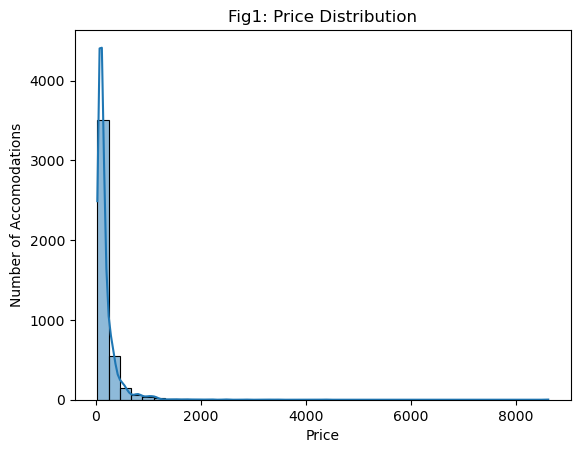

In [20]:
# Make a hist of the prices from the raw data
fig1 = sns.histplot(df_milan['price'],bins=40 ,kde=True)
fig1.set(title='Fig1: Price Distribution', xlabel='Price', ylabel='Number of Accomodations')
fig1

In [21]:
# Get an idea about outliers
df_milan['price'].describe(percentiles=[0.5,0.95])

count    4342.000000
mean      187.476969
std       259.741031
min        32.000000
50%       110.000000
95%       542.950000
max      8617.000000
Name: price, dtype: float64

In [22]:
# filter out outliers, which are probably errors or luxury hotels
filtered_milan = df_milan.loc[df_milan['price'] <= 550]

<Axes: title={'center': 'Fig2: Filtered Price Distribution'}, xlabel='Price', ylabel='Number of Accomodations'>

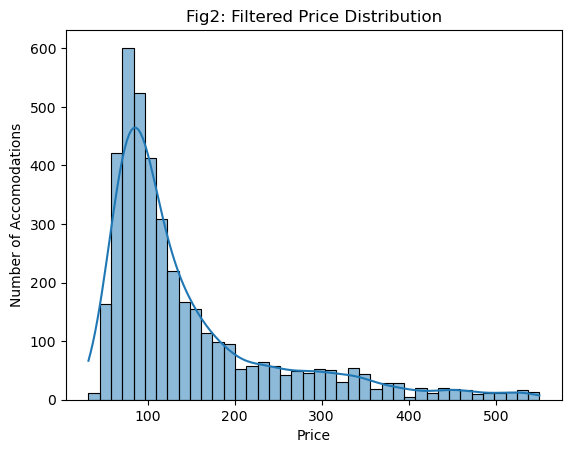

In [23]:
# Make a hist of the prices without outliers
fig2 = sns.histplot(filtered_milan['price'],bins=40 ,kde=True)
fig2.set(title='Fig2: Filtered Price Distribution', xlabel='Price', ylabel='Number of Accomodations')
fig2

In [24]:
# create log price
filtered_milan["lnp"] = np.log(filtered_milan["price"])

<Axes: title={'center': 'Fig3: Natural Logarithm of Price Distribution'}, xlabel='Ln Price', ylabel='Number of Accomodations'>

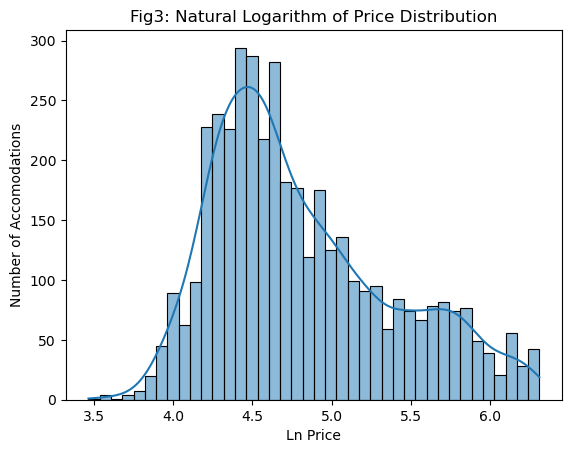

In [25]:
fig3 = sns.histplot(filtered_milan["lnp"],bins=40 ,kde=True)
fig3.set(title='Fig3: Natural Logarithm of Price Distribution', xlabel='Ln Price', ylabel='Number of Accomodations')
fig3

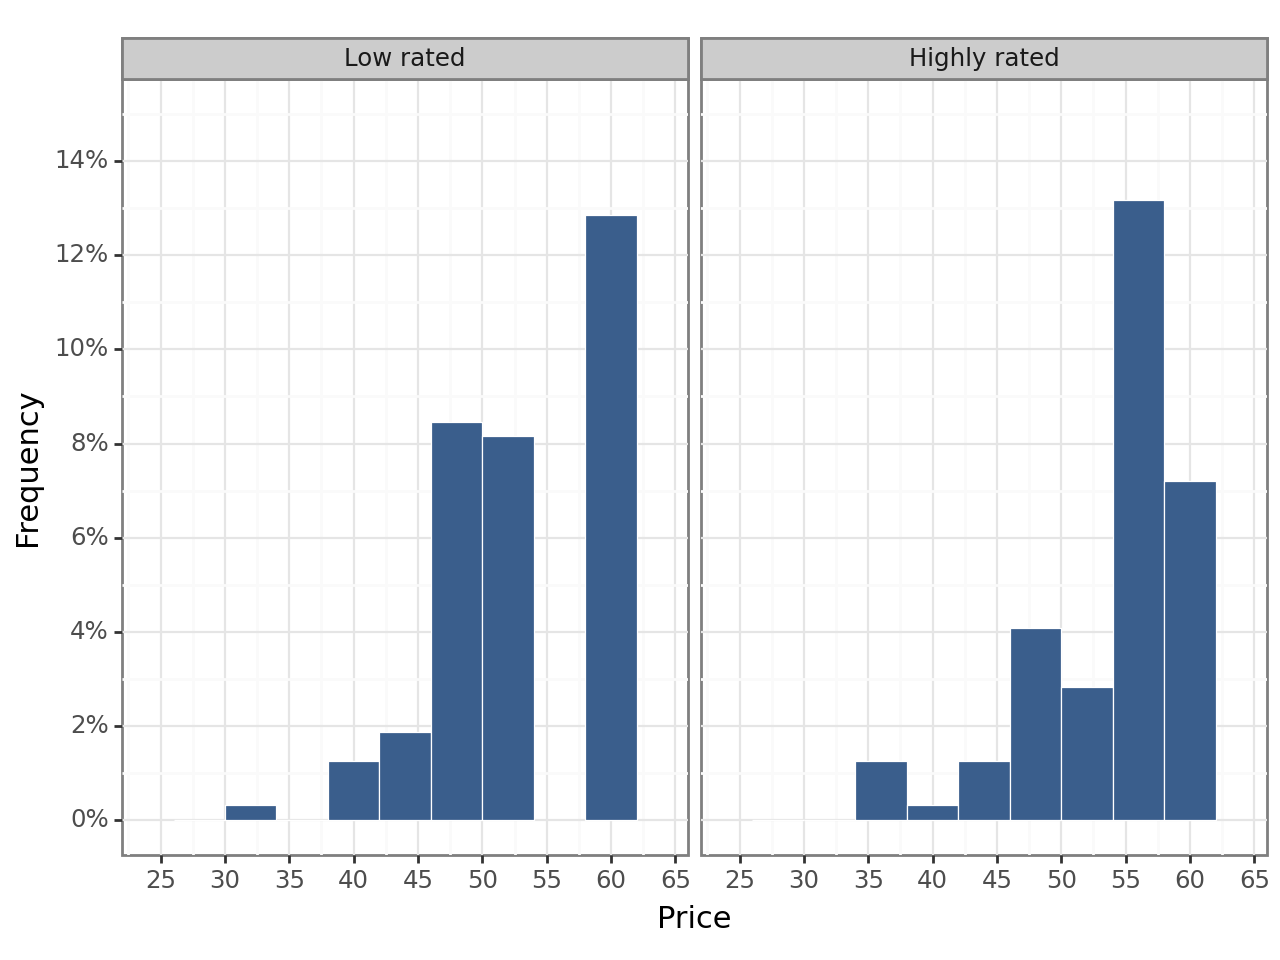

<Figure Size: (640 x 480)>

In [26]:
# Plot Price Distribution seperately for high and low rated
(
    ggplot(filtered_milan, aes(x="price", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=4,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
    )
    + facet_wrap("~highly_rated", labeller={"0": "Low rated", "1": "Highly rated"})
    + labs(x="Price", y="Frequency")
    + scale_x_continuous(
        limits=(24, 64),
        breaks=seq(25, 65, by=5),
    )
    + scale_y_continuous(
        limits=(0, 0.15), breaks=seq(0, 0.15, by=0.02), labels=percent_format()
    )
    + theme_bw()
)

## Distance filtering

In [27]:
# Check for null values
filtered_milan['distance'].isnull().sum()

0

<Axes: title={'center': 'Fig4: Distance Distribution'}, xlabel='Distance', ylabel='Number of Accomodations'>

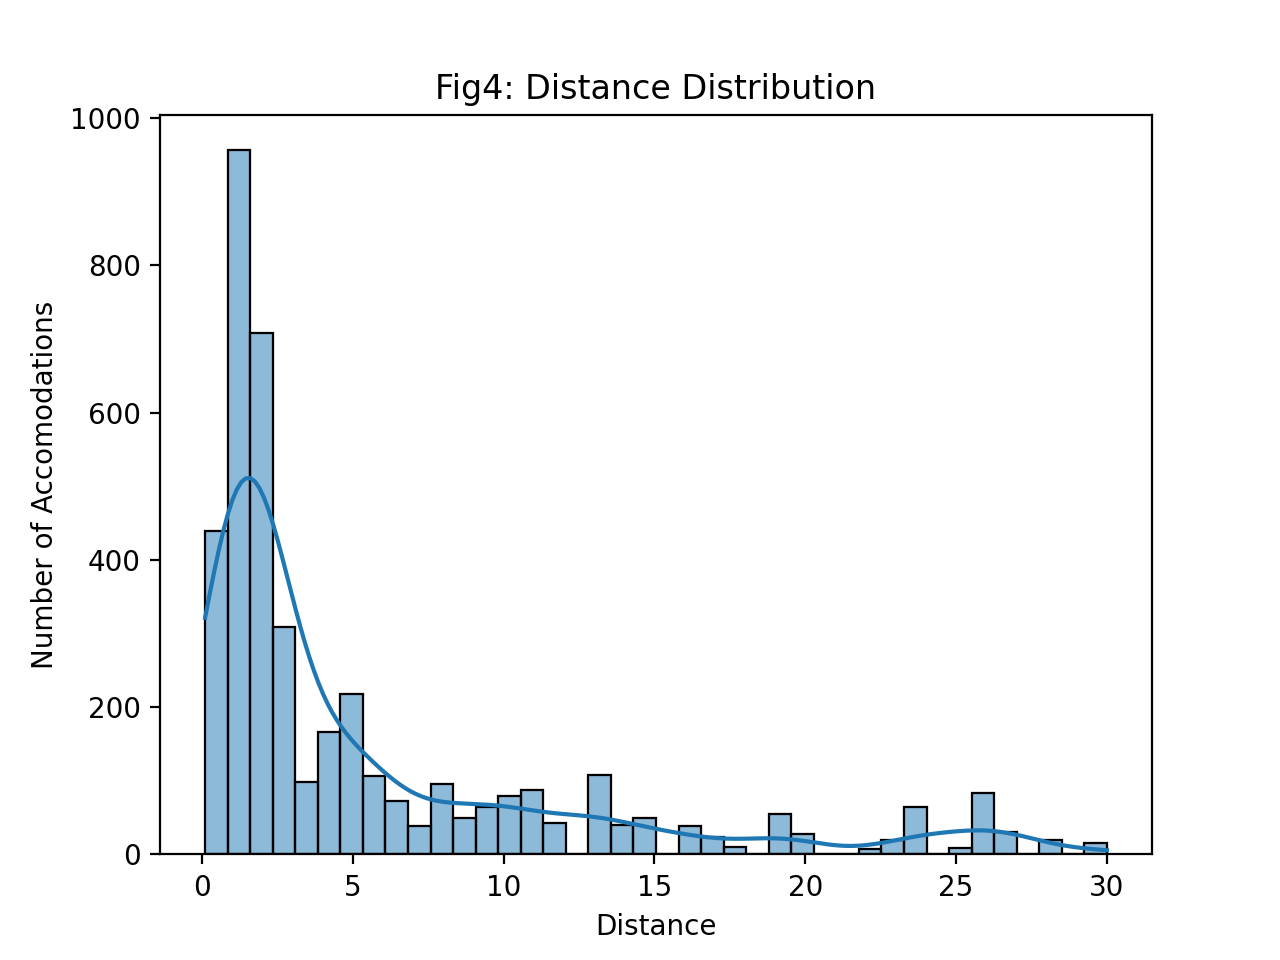

In [28]:
# Make a hist of the distance from the price filtered data
fig4 = sns.histplot(filtered_milan['distance'],bins=40 ,kde=True)
fig4.set(title='Fig4: Distance Distribution', xlabel='Distance', ylabel='Number of Accomodations')
fig4

In [29]:
# Get an idea about outliers
filtered_milan['distance'].describe(percentiles=[0.5,0.95])

count    4134.000000
mean        5.566086
std         6.773454
min         0.100000
50%         2.200000
95%        24.000000
max        30.000000
Name: distance, dtype: float64

In [30]:
# filter out outliers, which are probably errors (very far from city centre)
filtered_milan = filtered_milan.loc[filtered_milan['distance'] <= 10] # 10 km becasue it covers all the city 
print(f"We still have {filtered_milan['hotel_id'].unique().shape[0]} uniqe hotels in this table.")

We still have 439 uniqe hotels in this table.


<Axes: title={'center': 'Fig5: Distance Distribution'}, xlabel='Distance', ylabel='Number of Accomodations'>

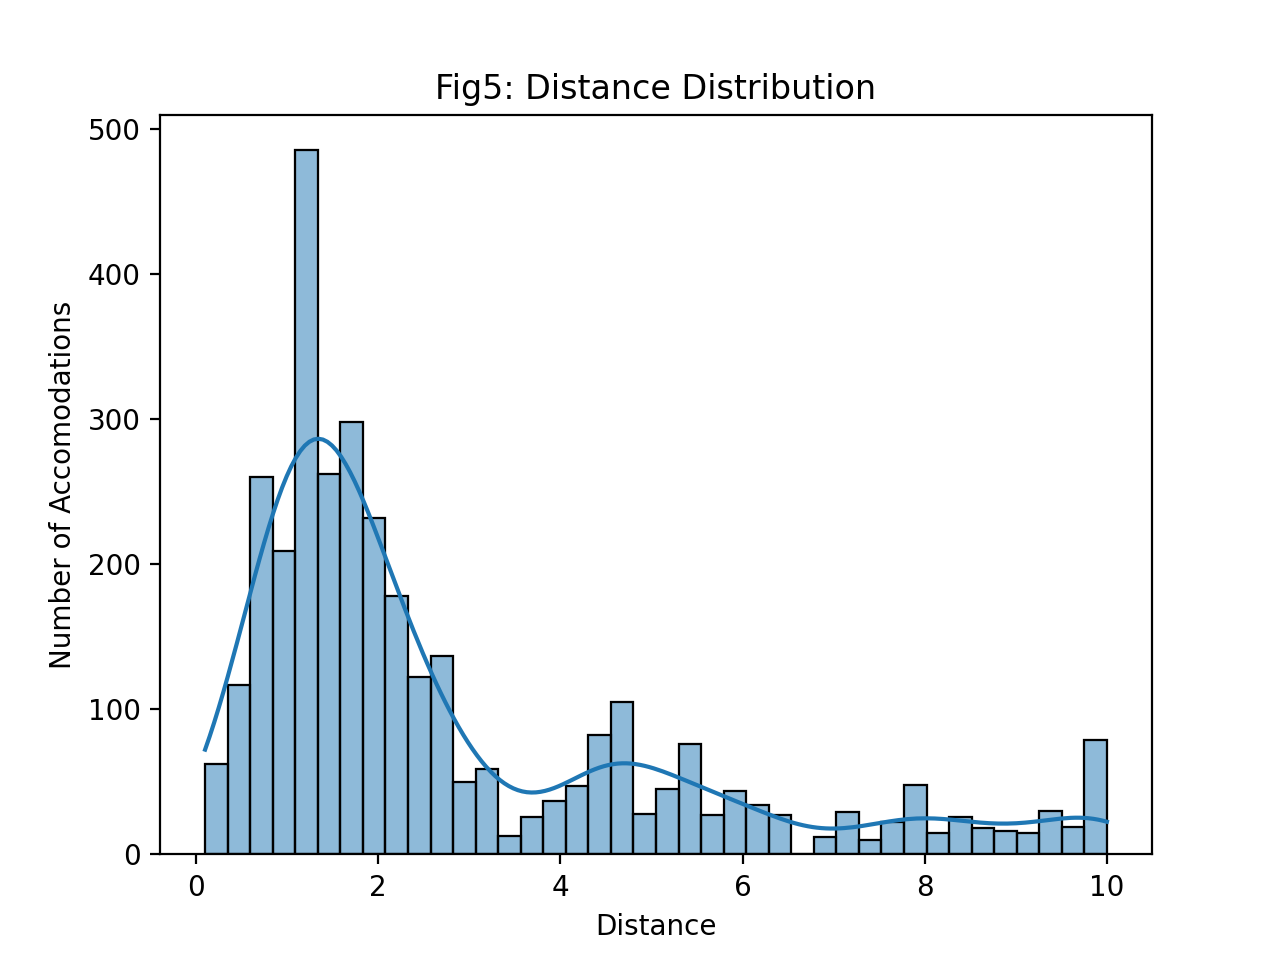

In [31]:
# Make a hist of the distance from the filtered data
fig5 = sns.histplot(filtered_milan['distance'],bins=40 ,kde=True)
fig5.set(title='Fig5: Distance Distribution', xlabel='Distance', ylabel='Number of Accomodations')
fig5

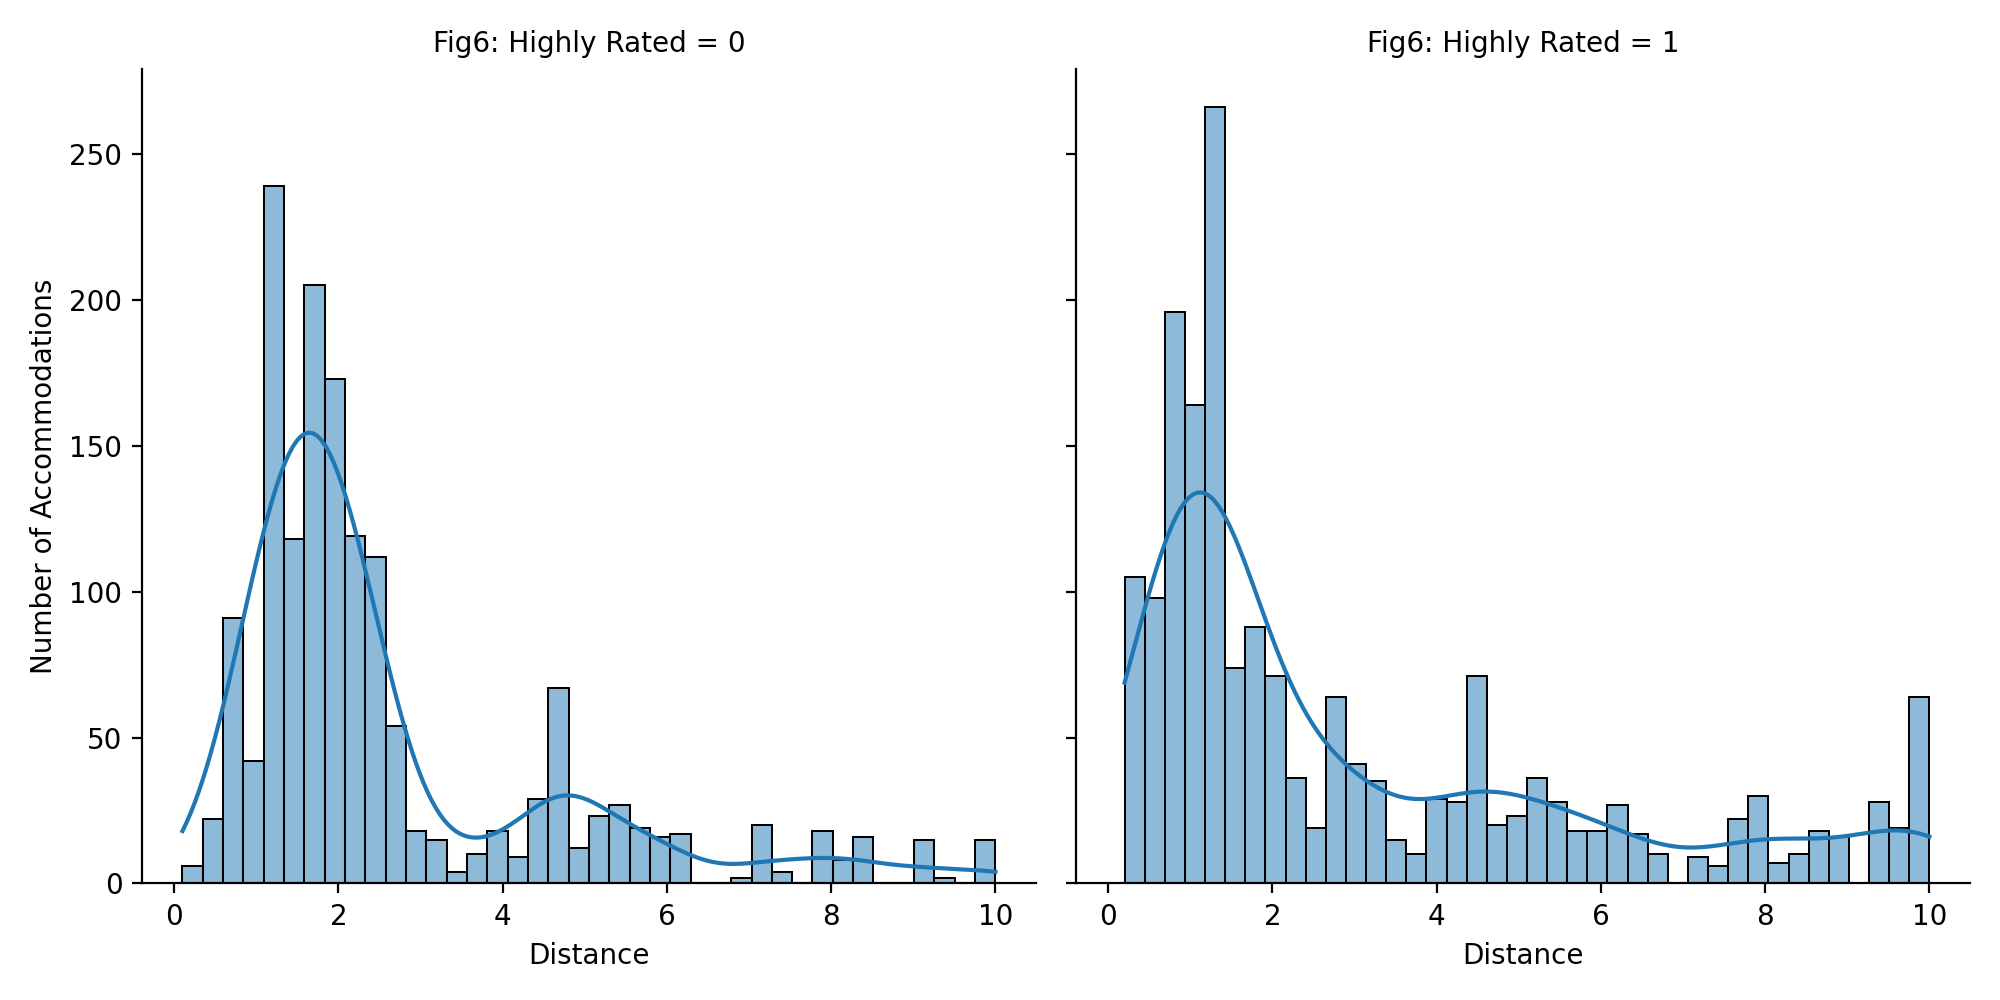

In [32]:
# Create a FacetGrid in sns
grid = sns.FacetGrid(filtered_milan, col='highly_rated', height=5)
grid.map(sns.histplot, 'distance', bins=40, kde=True)

grid.set_titles(col_template='Fig6: Highly Rated = {col_name}')
grid.set_axis_labels(x_var='Distance', y_var='Number of Accommodations')

plt.show()

## Stars filtering

In [33]:
# Check for null values
print(f'''There are {filtered_milan["stars"].shape[0]} values in the column out of which {filtered_milan["stars"].isnull().sum()} are null.      
We have {filtered_milan["stars"].count()} non-empty cells.''')

There are 3401 values in the column out of which 0 are null.      
We have 3401 non-empty cells.


In [34]:
filtered_milan['stars'].value_counts().reset_index().sort_values(by='index')

,index,stars
3,1.0,177
2,2.0,293
1,3.0,1078
5,3.5,10
0,4.0,1707
4,5.0,136


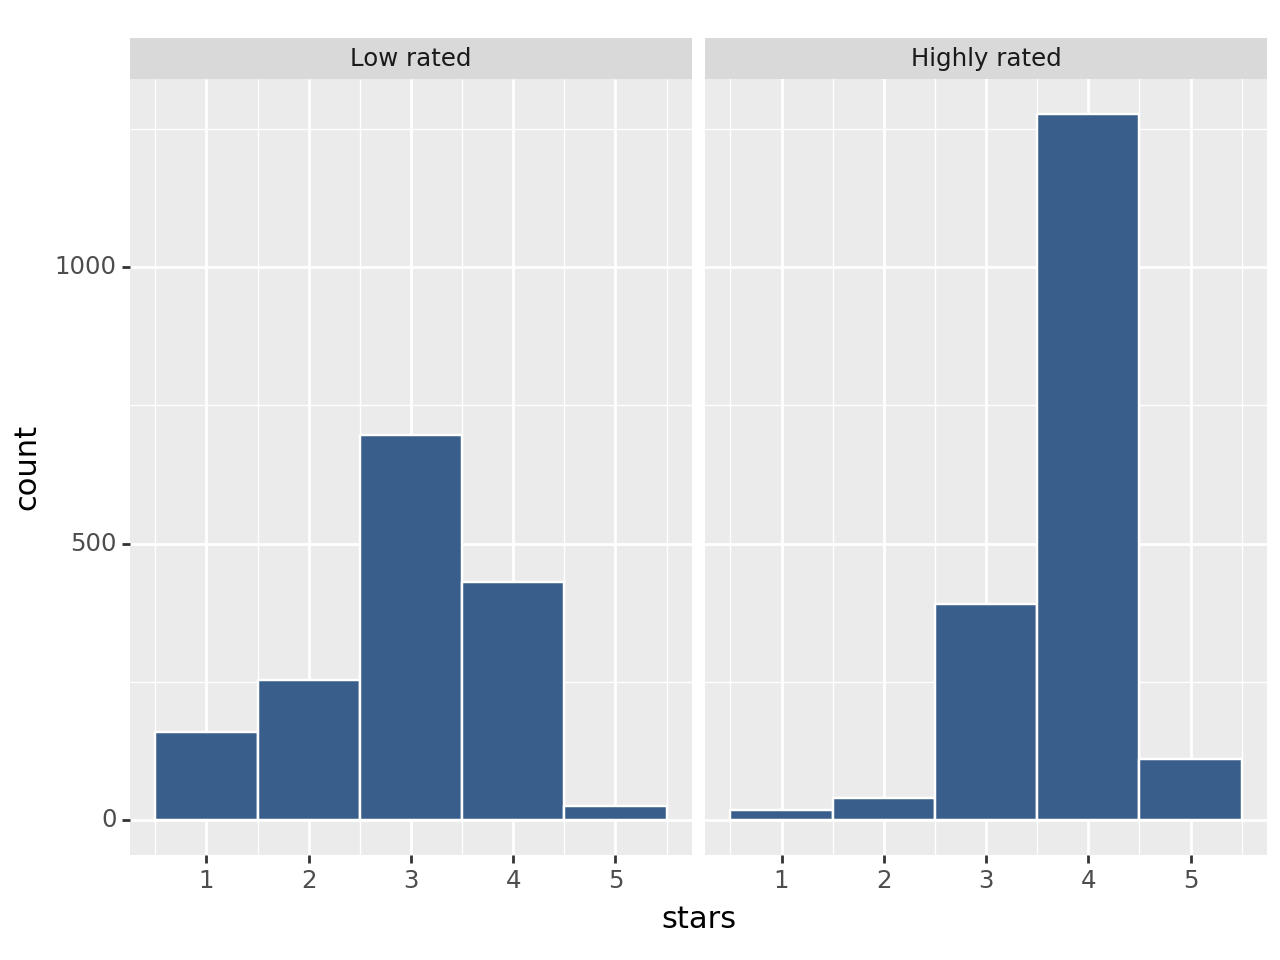

<Figure Size: (640 x 480)>

In [35]:
# Plot the distribution of stars
(ggplot(filtered_milan, aes(x="stars"))
 + geom_histogram(
     binwidth=1,
        color="white",
        fill=color[0])
+ facet_wrap("~highly_rated", labeller={"0": "Low rated", "1": "Highly rated"}))

In [36]:
# No need for filtering in this column

#### We examine 2 lowess regressions to decide what functional forms to include
- highly rated and ln price 
- highly rated and distance

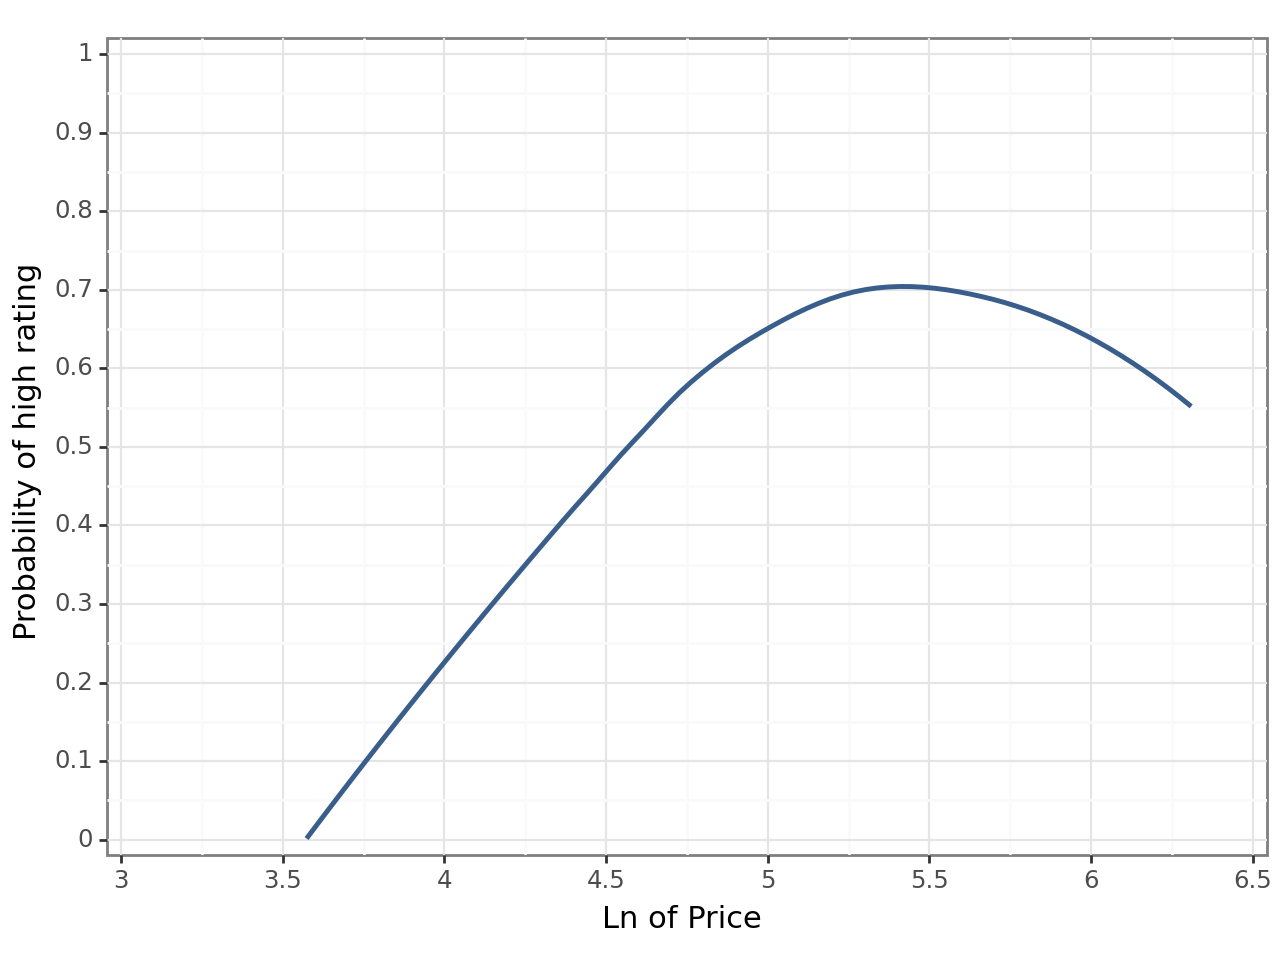

<Figure Size: (640 x 480)>

In [37]:
g2a = (
    ggplot(data=filtered_milan)
    + geom_smooth(
        aes(x="lnp", y="highly_rated"), method="loess", se=False, color=color[0]
    )
    + labs(
       x="Ln of Price ", y="Probability of high rating "
    )
    # + coord_cartesian(xlim = [0, 1], ylim=[0,1])
    + scale_x_continuous(expand=[0.01, 0.01], limits=[3, 6.5], breaks=seq(3, 6.5, 0.5))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.1))
    + theme_bw()
)
g2a

In [38]:
# we can create 2 splines for price column: knot at 5.4 
# - include ln_price as a piecewise linear spline with a this knot


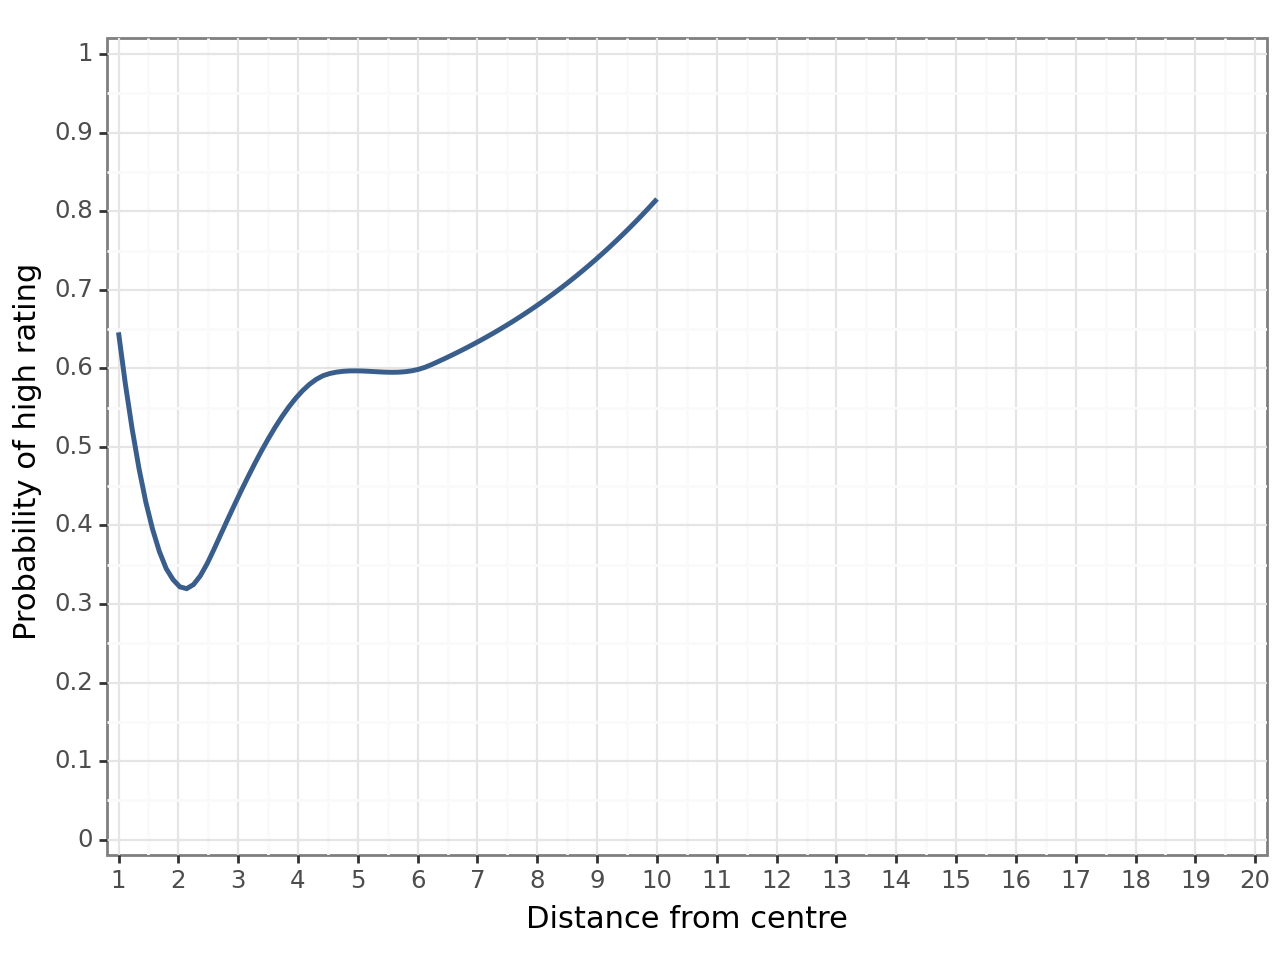

<Figure Size: (640 x 480)>

In [39]:
g2b = (
    ggplot(data=filtered_milan)
    + geom_smooth(
        aes(x="distance", y="highly_rated"), method="loess", se=False, color=color[0]
    )
    + labs(
       x="Distance from centre", y="Probability of high rating "
    )
    + scale_x_continuous(expand=[0.01, 0.01], limits=[1, 20], breaks=seq(0, 20, 1))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.1))
    + theme_bw()
)
g2b

In [40]:
# we can create 3 splines for distance column: knots at 2.5 and 4.5
# -include distance as a piecewise linear spline with a these knots

#  2. PART - SIMPLE LPM MODELS

**Model 1**: estimate linear probability model
- Hotels rated equal to or higher than 4.0 (*highly_rated*) as the binary dependent variable 
- Distance from center as explanatory variable (*distance*)

In [50]:
lpm1 = smf.ols("highly_rated ~ distance + stars", data=filtered_milan).fit(cov_type="HC1")
stargazer = Stargazer([lpm1])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

**Model 2**: include *stars*

In [51]:
lpm2 = smf.ols("highly_rated ~ stars + lspline(distance, [2.5,4.5]) + lspline(lnp, [5.4])", data=filtered_milan).fit(cov_type="HC1")
stargazer = Stargazer([lpm2])
stargazer.covariate_order([
    "stars",
    "lspline(distance, [2.5, 4.5])[0]",
    "lspline(distance, [2.5, 4.5])[1]",
    "lspline(distance, [2.5, 4.5])[2]",
    "lspline(lnp, [5.4])[0]",
    "lspline(lnp, [5.4])[1]"
])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

In [ ]:
# interpret the coefficients:

### Table 1.1 Probability of high rating

In [54]:
stargazer = Stargazer([lpm1, lpm2])
stargazer.covariate_order(["Intercept","distance","stars",
    "lspline(distance, [2.5, 4.5])[0]",
    "lspline(distance, [2.5, 4.5])[1]",
    "lspline(distance, [2.5, 4.5])[2]",
    "lspline(lnp, [5.4])[0]",
    "lspline(lnp, [5.4])[1]"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

In [55]:
lpm1.conf_int(alpha=0.01)

,0,1
Intercept,-0.415411,-0.277894
distance,-0.001590,0.014453
stars,0.236584,0.275225


**Model 1**: $highly_rated^P=\alpha+\beta distance$
- $\alpha$: 62% of non-smokers ($smoking=0$) stayed healthy
- $\beta$: smokers were 7% less likely to stay healthy
> 62-7=55% of smokers stayed healthy

estimates are statistically significant at 1%
- statistically different from 0, so we can be 99% confident that smokers are less likely to stay healthy in the population (represented by the dataset)
- we can be 99% confident that the smokers in the population (represented by the dataset) stay healthy with a lower probability of 1.5 to 12.5 percentage points

Note - population: 50-60-year-old people, from 14 European countries, who consider themselves healthy